In [3]:
# TODO 
# box bounding before keypoints prediction
# SineReLU
# fastai/pytorch
# fully connected network

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from random import randint

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (Dense, Activation, SeparableConv2D, MaxPooling2D, Flatten, Dropout, 
                          BatchNormalization)
from keras.optimizers import Adam

import imgaug
from imgaug import augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

from preprocess import load, generator
from utils import plot_labelled_image, plot_labelled_sample, plot_loss, load_model, save_model
from model import MyModel, Resnet50Model

In [9]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'
target_size = 80

In [10]:
X, y = load(images_path, labels_path, target_size)

X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(4192, 80, 80, 3) (898, 80, 80, 3) (899, 80, 80, 3)


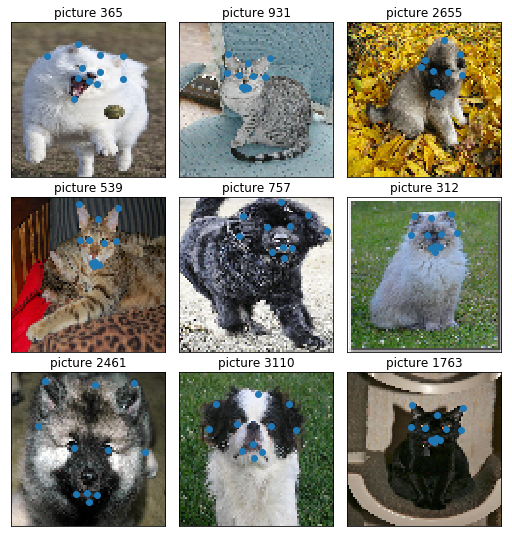

In [11]:
plot_labelled_sample(X_train, y_train, target_size, False)

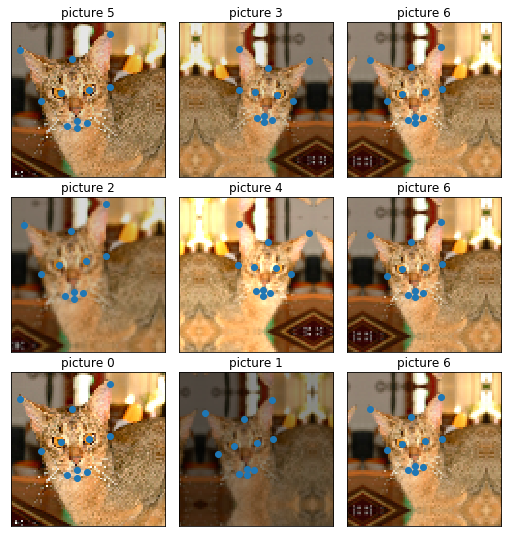

In [12]:
for a, b in generator(X[2:3], y.iloc[2:3], 9, target_size):
    plot_labelled_sample(a, b, target_size)   
    break

In [15]:
model = Resnet50Model(target_size, 1e-3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_4 (Dense)              (None, 22)                5654      
Total params: 28,312,214
Trainable params: 4,724,502
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
epochs = 50
batch_size = 128
max_lr = 0.001

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='../models/my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

hist = model.fit_generator(
    generator(X_train, y_train, batch_size=batch_size, target_size=target_size), 
    steps_per_epoch=len(X_train)/batch_size, 
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=(X_val/255, (y_val - (target_size/2)) / (target_size/2))
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
33/32 [==============================] - 71s 2s/step - loss: 1.4423 - val_loss: 0.1568
Epoch 2/50
33/32 [==============================] - 64s 2s/step - loss: 0.1341 - val_loss: 0.1517
Epoch 3/50
33/32 [==============================] - 64s 2s/step - loss: 0.1307 - val_loss: 0.1461
Epoch 4/50
33/32 [==============================] - 64s 2s/step - loss: 0.1253 - val_loss: 0.1403
Epoch 5/50
33/32 [==============================] - 64s 2s/step - loss: 0.1222 - val_loss: 0.1345
Epoch 6/50
33/32 [==============================] - 64s 2s/step - loss: 0.1169 - val_loss: 0.1291
Epoch 7/50
33/32 [==============================] - 63s 2s/step - loss: 0.1096 - val_loss: 0.1242
Epoch 8/50
33/32 [==============================] - 63s 2s/step - loss: 0.1077 - val_loss: 0.1195
Epoch 9/50
33/32 [==============================] - 63s 2s/step - loss: 0.1058 - val_loss: 0.1151
Epoch 10/50
33/32 [==============================] - 63s 2s/step - los

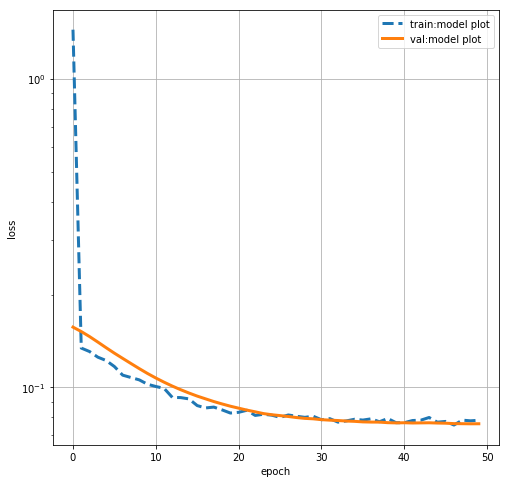

In [17]:
plot_loss(hist, "model plot")

In [18]:
model.load_weights('../models/my_model.h5')

In [19]:
model = load_model("my_model")
save_model(model, "my_model")

In [20]:
y_pred = pd.DataFrame(model.predict(X_test/255))

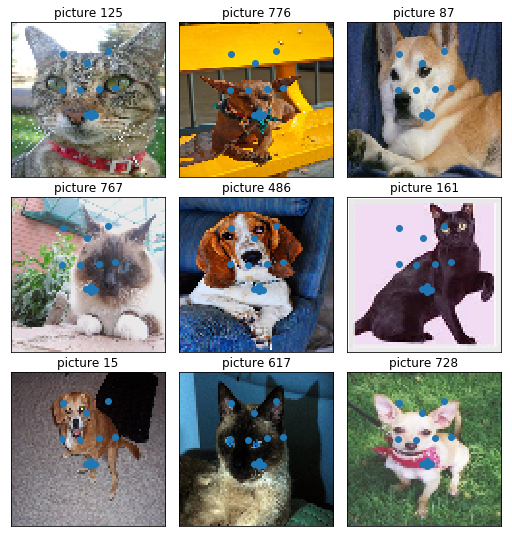

In [21]:
plot_labelled_sample(X_test/255, (y_pred - (target_size/2)) / (target_size/2), target_size)